> Auto-differentiable DRR synthesis and optimization in PyTorch

[![CI](https://github.com/eigenvivek/DiffDRR/actions/workflows/test.yaml/badge.svg)](https://github.com/eigenvivek/DiffDRR/actions/workflows/test.yaml)
[![Paper shield](https://img.shields.io/badge/arXiv-2208.12737-red.svg)](https://arxiv.org/abs/2208.12737)
[![License: MIT](https://img.shields.io/badge/License-MIT-blue.svg)](LICENSE)
[![Downloads](https://static.pepy.tech/personalized-badge/diffdrr?period=total&units=none&left_color=grey&right_color=blue&left_text=downloads)](https://pepy.tech/project/diffdrr)
[![Docs](https://github.com/eigenvivek/DiffDRR/actions/workflows/deploy.yaml/badge.svg)](https://vivekg.dev/DiffDRR/)
[![Code style: black](https://img.shields.io/badge/Code%20style-black-black.svg)](https://github.com/psf/black)

`DiffDRR` is a PyTorch-based digitally reconstructed radiograph (DRR) generator that provides

1. Auto-differentiable X-ray rendering
2. GPU-accelerated DRR synthesis
3. A pure Python implementation

Most importantly, `DiffDRR` implements DRR rendering as a PyTorch module, making it interoperable with deep learning pipelines.

Below is a comparison of `DiffDRR` to a real X-ray (X-rays and CTs from the [DeepFluoro dataset](https://github.com/rg2/DeepFluoroLabeling-IPCAI2020)):

![`DiffDRR` rendered from the same camera pose as a real X-ray.](index_files/deepfluoro.png)

## Install
To install `DiffDRR` from PyPI:
```zsh
pip install diffdrr
```

## Usage

The following minimal example specifies the geometry of the projectional radiograph imaging system and traces rays through a CT volume:

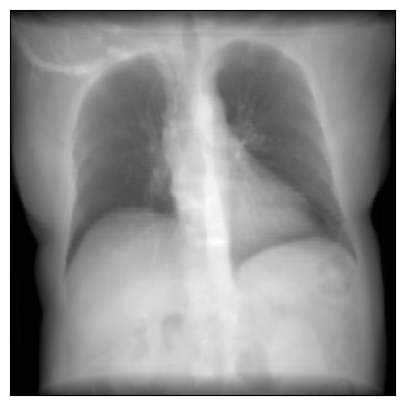

In [ ]:
import matplotlib.pyplot as plt
import torch

from diffdrr.drr import DRR
from diffdrr.data import load_example_ct
from diffdrr.visualization import plot_drr

# Read in the volume and get its origin and spacing in world coordinates
subject = load_example_ct()

# Initialize the DRR module for generating synthetic X-rays
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drr = DRR(
    subject,     # An object storing the CT volume, origin, and voxel spacing
    sdd=1020.0,  # Source-to-detector radius (half of the source-to-detector distance)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=2.0,    # Pixel spacing (in mm)
).to(device)

# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[0.0, torch.pi / 2, torch.pi / 2]], device=device)
translations = torch.tensor([[-10.0, 850.0, -175.0]], device=device)

# 📸 Also note that DiffDRR can take many representations of SO(3) 📸
# For example, quaternions, rotation matrix, axis-angle, etc...
img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
plot_drr(img, ticks=False)
plt.show()

On a single NVIDIA RTX 2080 Ti GPU, producing such an image takes

In [ ]:
# |code-fold: false
%timeit drr(rotations, translations, parameterization="euler_angles", convention="ZYX")

34.9 ms ± 22.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The full example is available at [`introduction.ipynb`](https://vivekg.dev/DiffDRR/tutorials/introduction.html).

## 2D/3D Registration

We demonstrate the utility of our auto-differentiable DRR generator by solving the 2D/3D registration problem with gradient-based optimization. Here, we generate two DRRs:

1. A fixed DRR from a set of ground truth parameters
2. A moving DRR from randomly initialized parameters

To solve the registration problem, we use gradient descent to maximize an image loss similarity metric between the two DRRs.
This produces optimization runs like this:

![](https://cdn.githubraw.com/eigenvivek/DiffDRR/7a6a44aeab58d19cc7a4afabfc5aabab3a494974/experiments/registration/results/momentum_dampen/gifs/converged/649.gif)

The full example is available at [`optimizers.ipynb`](https://vivekg.dev/DiffDRR/tutorials/optimizers.html).

## Development

`DiffDRR` source code, docs, and CI are all built using
[`nbdev`](https://nbdev.fast.ai/). To get set up with `nbdev`, install
the following

``` zsh
mamba install jupyterlab nbdev -c fastai -c conda-forge 
nbdev_install_quarto  # To build docs
nbdev_install_hooks   # Make notebooks git-friendly
```

Running `nbdev_help` will give you the full list of options. The most
important ones are

``` zsh
nbdev_preview  # Render docs locally and inspect in browser
nbdev_clean    # NECESSARY BEFORE PUSHING
nbdev_test     # tests notebooks
nbdev_export   # builds package and builds docs
```

For more details, follow this [in-depth
tutorial](https://nbdev.fast.ai/tutorials/tutorial.html).

## How does `DiffDRR` work?

`DiffDRR` reformulates Siddon's method,[^1] the canonical algorithm for calculating the radiologic path of an X-ray through a volume, as a series of vectorized tensor operations. This version of the algorithm is easily implemented in tensor algebra libraries like PyTorch to achieve a fast auto-differentiable DRR generator.

[^1]: [Siddon RL. Fast calculation of the exact radiological path for a three-dimensional CT array.
Medical Physics, 2(12):252–5, 1985.](https://doi.org/10.1118/1.595715)

## Citing `DiffDRR`

If you find `DiffDRR` useful in your work, please cite our [paper](https://doi.org/10.1007/978-3-031-23179-7_1) (or the [freely accessible arXiv version](https://arxiv.org/abs/2208.12737)):

```
@inproceedings{gopalakrishnanDiffDRR2022,
    author    = {Gopalakrishnan, Vivek and Golland, Polina},
    title     = {Fast Auto-Differentiable Digitally Reconstructed Radiographs for Solving Inverse Problems in Intraoperative Imaging},
    year      = {2022},
    booktitle = {Clinical Image-based Procedures: 11th International Workshop, CLIP 2022, Held in Conjunction with MICCAI 2022, Singapore, Proceedings},
    series    = {Lecture Notes in Computer Science},
    publisher = {Springer},
    doi       = {https://doi.org/10.1007/978-3-031-23179-7_1},
}
```